## DM-34693: Investigate lack of solar system matches in ap_verify runs

Notebook for various debugging tasks in this ticket.

In [1]:
import os
import numpy as np

import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import lsst.geom
afwDisplay.setDefaultBackend('firefly')
import matplotlib.ticker as plticker
import lsst.afw.cameraGeom.testUtils as testUtils
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.hsc import HscMapper as mapper
import lsst.daf.butler as dafButler
from skimage.filters import gaussian
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from operator import itemgetter
from itertools import groupby

import astropy.units as u
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
import astropy.coordinates as coord
import pyarrow.parquet as pq
import lsst.daf.butler as dafButler



Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+164b02c8d4/config/.dustmapsrc


In [2]:
import sys
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [3]:
collection='ap_verify-output'
repo = '/scratch/krzys001/sso_demo/repo/'
butler = dafButler.Butler(repo, collections=collection)

In [4]:
ephem = butler.get("visitSsObjects", visit=411420)
filtered = ephem.loc[ephem.apply(lambda x: x["ssObjectId"] in {43707620656988304, 44866635817748191, 15168997349454932}, axis=1),
                     ['Name', 'ra', 'decl', 'Mv', 'Err(arcsec)', 'Phase(deg)', 'ssObjectId']]

In [5]:
filtered

,Name,ra,decl,Mv,Err(arcsec),Phase(deg),ssObjectId
9,2015 DL180,154.829397,-5.755249,21.4,0.740,5.82,43707620656988304
11,2000 SS305,154.891963,-5.847119,20.1,0.226,5.74,44866635817748191
12,2016 LG24,155.209887,-5.957342,21.3,1.491,5.69,15168997349454932


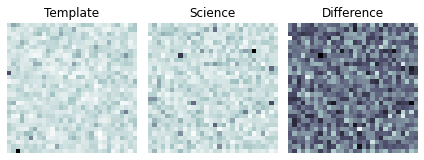

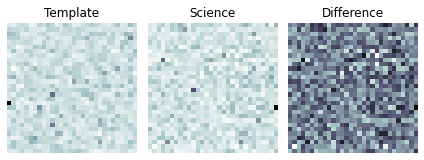

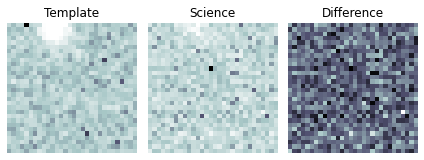

In [6]:
for index,x in filtered.iterrows():
    
    dataId = {"instrument": "DECam", "visit": 411420, "detector": 5}
    sp = lsst.geom.SpherePoint(x.ra, x.decl, lsst.geom.degrees)
    try:
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collection, sp)
        plc.plotCutout(scienceCutout, differenceCutout, templateCutout)   
    except:
        dataId = {"instrument": "DECam", "visit": 411420, "detector": 10}
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collection, sp)
        plc.plotCutout(scienceCutout, differenceCutout, templateCutout)

In [7]:
cexp = butler.get("calexp",dataId=dataId,collections=collection)

In [8]:
cexp.getWcs().pixelToSky([lsst.geom.Point2D(x) for x in cexp.getBBox().getCorners()])

[SpherePoint(154.97054081071053*degrees, -5.866078103626195*degrees),
 SpherePoint(154.97035160372852*degrees, -6.015527515614197*degrees),
 SpherePoint(155.27171929820906*degrees, -6.015661272282916*degrees),
 SpherePoint(155.27166556312434*degrees, -5.866241519558192*degrees)]

So, looks like the source locations are indeed within the expected bounding boxes, but as seen in the cutouts, there's really nothing to detect at those locations.